# Content-Based Recommender System
**Author: Juan Acosta**

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### Motivation
I'd like to test a content-based recommender system using a new dataset that includes metadata such as game genre, platform, and publisher. Previously, I built a collaborative filtering system using only user ratings as a feature, but this new system will incorporate additional details about the games themselves.

You can take a look at the collaborative-filter system i made on [here](https://github.com/JuanMa894/VGames-rec-system/blob/main/Game_recommender_system.ipynb)

## Data understanding
The dataset that I'm using for the content-based system consists of a total of 11,493 unique video game titles across 31 different platforms. This information was gathered from [VGchartz](https://www.vgchartz.com/) and can be accessed on the Kaggle platform [here](https://www.kaggle.com/datasets/gregorut/videogamesales).

Columns:
- Rank - Ranking of overall sales
- Name - The games name
- Platform - Platform of the games release (i.e. PC,PS4, etc.)
- Year - Year of the game's release
- Genre - Genre of the game
- Publisher - Publisher of the game
- NA_Sales - Sales in North America (in millions)
- EU_Sales - Sales in Europe (in millions)
- JP_Sales - Sales in Japan (in millions)
- Other_Sales - Sales in the rest of the world (in millions)
- Global_Sales - Total worldwide sales.

In [229]:
df = pd.read_csv('./data/vgsales.csv')

# keeping only the needed features
df = df[['Name', 'Platform', 'Genre', 'Publisher']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Name       16598 non-null  object
 1   Platform   16598 non-null  object
 2   Genre      16598 non-null  object
 3   Publisher  16540 non-null  object
dtypes: object(4)
memory usage: 518.8+ KB


In [230]:
# checking unique values for each feature
df.nunique()

Name         11493
Platform        31
Genre           12
Publisher      578
dtype: int64

In [231]:
# Null values
df.isna().sum()

Name          0
Platform      0
Genre         0
Publisher    58
dtype: int64

In [232]:
df[df.isna().any(axis=1)]

,Name,Platform,Genre,Publisher
470,wwe Smackdown vs. Raw 2006,PS2,Fighting,NaN
1303,Triple Play 99,PS,Sports,NaN
1662,Shrek / Shrek 2 2-in-1 Gameboy Advance Video,GBA,Misc,NaN
2222,Bentley's Hackpack,GBA,Misc,NaN
3159,Nicktoons Collection: Game Boy Advance Video V...,GBA,Misc,NaN
3166,SpongeBob SquarePants: Game Boy Advance Video ...,GBA,Misc,NaN
3766,SpongeBob SquarePants: Game Boy Advance Video ...,GBA,Misc,NaN
4145,Sonic the Hedgehog,PS3,Platform,NaN
4526,The Fairly Odd Parents: Game Boy Advance Video...,GBA,Misc,NaN
4635,The Fairly Odd Parents: Game Boy Advance Video...,GBA,Misc,NaN


I will remove entries that have 'Game Boy Advance Video Volume' in the name and a null value in the Publisher column because these are actually TV shows that were sold to be played on the Game Boy console, not actual games.

In [233]:
df['Platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       '3DS', 'PS4', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne', 'GC',
       'WiiU', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

## Data Preparation

In [234]:
# droping null values
df.dropna(inplace=True)

By converting all game titles to lowercase, the system can avoid errors that might occur if the user inputs a title with a different case format. This is because comparisons between strings are case-sensitive, so "Super Mario Bros." and "super mario bros." would be treated as two different strings. i will convert all titles to lowercase so they will match regardless of the case

In [235]:
# setting all game titles to lowercase
df['Name'] = df['Name'].apply(str.lower)

CountVectorizer is a tool from the scikit-learn library in Python that can be used to convert a collection of text documents to a matrix of token counts, documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [257]:
# Combining features to fit into CountVectorizer
def combined_features(row):
    return row['Platform']+" "+row['Genre']+" "+row['Publisher']
df["combined_features"] = df.apply(combined_features, axis =1)

In [258]:
df["combined_features"]

0             Wii Sports Nintendo
1           NES Platform Nintendo
2             Wii Racing Nintendo
3             Wii Sports Nintendo
4        GB Role-Playing Nintendo
                   ...           
16593          GBA Platform Kemco
16594       GC Shooter Infogrames
16595       PS2 Racing Activision
16596          DS Puzzle 7G//AMES
16597        GBA Platform Wanadoo
Name: combined_features, Length: 16540, dtype: object

In [259]:
cv = CountVectorizer()
c_matrix = cv.fit_transform(df["combined_features"])
c_matrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

CountVectorizer counts the number of times each word in the vocabulary appears in the document and stores the count in a matrix.

# Cosine similarity

Cosine similarity is a measure of similarity between two non-zero vectors in an inner product space. It calculates the cosine of the angle between the vectors by dividing the dot product of the vectors by the product of their magnitudes. The closer the result is to 1, the more similar the two vectors are.

I use cosine similarity to compare the vectors representing each game in the dataset and calculate the similarity score between them. These scores are calculated for every combination of games in the dataset.

In [260]:
cosine_sim = cosine_similarity(c_matrix)

In [261]:
# Use title of games liked by user and desired number of recommendations as input for the system
game_liked = str.lower(input('A game you like: '))
nRec2 = int(input('Number of recommendations? '))

A game you like: pokemon red/pokemon blue
Number of recommendations? 5


In [262]:
liked_game_index = df[df.Name == game_liked].index.values[0]

#sorting cosine similarities by highest to lowest
sim_scores = list(enumerate(cosine_sim[liked_game_index]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

#matching the similarities to the game title
sim_games = []
for i in range(1, nRec2+1):
    game_index = sim_scores[i][0]
    sim_games.append(df['Name'].iloc[game_index])
    
sim_games

['pokemon gold/pokemon silver',
 'pokémon yellow: special pikachu edition',
 'pokémon crystal version',
 'hamtaro: ham-hams unite!',
 'pokemon diamond/pokemon pearl']

Similar to my collaborative filtering system, i will use matplotlib to create a figure object and return it with the games names on it. This figure can then be displayed to the user as a visual outcome of the recommendation.

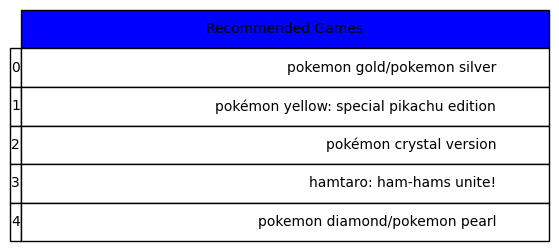

In [271]:
#creating fig to display dataframe
fig = plt.figure(figsize=(15,3))
font_size=10

#creating new daframe using sim_games list
p_df = pd.DataFrame(sim_games, columns=(['Recommended Games']))

#Returning games recommended to user 
ax1 = fig.add_subplot(121)
bbox=[0, 0, 1, 1]
ax1.axis('off')
mpl_table1 = ax1.table(cellText = p_df.values, rowLabels = p_df.index, bbox=bbox, colLabels=p_df.columns, colColours='blue')
mpl_table1.auto_set_font_size(False)
mpl_table1.set_fontsize(font_size)


### Recommender function

In [272]:
def Get_game():
    game_liked = str.lower(input('A game you like: '))
    nRec2 = int(input('Number of recommendations? '))
    
    liked_game_index = df[df.Name == game_liked].index.values[0]


    sim_scores = list(enumerate(cosine_sim[liked_game_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)


    sim_games = []
    for i in range(1, nRec2+1):
        game_index = sim_scores[i][0]
        sim_games.append(df['Name'].iloc[game_index])
    
    
    fig = plt.figure(figsize=(15,3))
    font_size=10

    p_df = pd.DataFrame(sim_games, columns=(['Recommended Games']))

    ax1 = fig.add_subplot(121)
    bbox=[0, 0, 1, 1]
    ax1.axis('off')
    mpl_table1 = ax1.table(cellText = p_df.values, rowLabels = p_df.index, bbox=bbox, colLabels=p_df.columns, colColours='blue')
    mpl_table1.auto_set_font_size(False)
    mpl_table1.set_fontsize(font_size)

**Testing function**

In [279]:
# getting random sample of game titles
game_sample = df.sample(3)
game_sample['Name'].values

array(['n3 ii: ninety-nine nights',
       'metal gear solid 4: guns of the patriots', '1001 touch games'],
      dtype=object)

A game you like: power rangers samurai
Number of recommendations? 3


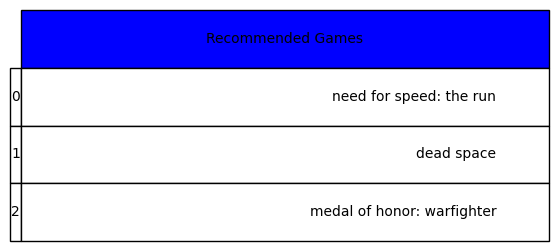

In [275]:
Get_game()

A game you like: metal gear solid 4: guns of the patriots
Number of recommendations? 5


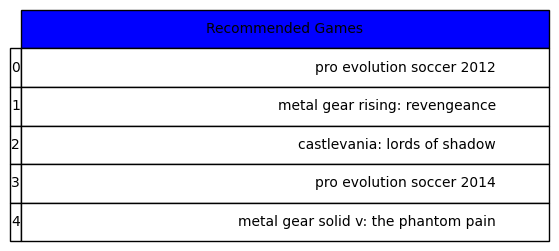

In [281]:
Get_game()

## Conclusion 

### Resources:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
https://towardsdatascience.com/using-cosine-similarity-to-build-a-movie-recommendation-system-ae7f20842599
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
